In [17]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import Linear, MSELoss, Sequential, Sigmoid, Softmax, ReLU, LeakyReLU, Module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.interpolate import make_interp_spline, BSpline

In [18]:
df = pd.read_csv('io-bytes-experimental-group.csv')
df

,vms,bytesIn,bytesOut
0,10,94409,54308
1,10,94051,53708
2,10,93617,54394
3,20,674656,208973
4,20,676367,208445
5,20,670885,210163
6,30,2219595,460397
7,30,2200792,460377
8,40,5159332,813267
9,40,5171508,812587


In [19]:
df.corr()

,vms,bytesIn,bytesOut
vms,1.000000,0.957067,0.985316
bytesIn,0.957067,1.000000,0.992239
bytesOut,0.985316,0.992239,1.000000


In [20]:
df = df.dropna() # drop all rows that have NAN/none
df['sum'] = (df['bytesIn']+df['bytesOut'])/1024
df.insert(0, "squared_vms", df['vms']**2, True)
df

,squared_vms,vms,bytesIn,bytesOut,sum
0,100,10,94409,54308,145.231445
1,100,10,94051,53708,144.295898
2,100,10,93617,54394,144.541992
3,400,20,674656,208973,862.918945
4,400,20,676367,208445,864.074219
5,400,20,670885,210163,860.398438
6,900,30,2219595,460397,2617.179688
7,900,30,2200792,460377,2598.797852
8,1600,40,5159332,813267,5832.616211
9,1600,40,5171508,812587,5843.842773


In [21]:
x_data = df.iloc[:,:2].values # 0, 1 열 (x^2 + x)
y_data = df.iloc[:,[-1]].values  # 마지막 열만
print(x_data.shape)


(14, 2)


In [22]:

scaleF = MinMaxScaler()
x_dataN = scaleF.fit_transform( x_data )

scaleL = MinMaxScaler()
y_dataN = scaleL.fit_transform( y_data )
y_dataN.shape

x_dataN

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.125     , 0.25      ],
       [0.125     , 0.25      ],
       [0.125     , 0.25      ],
       [0.33333333, 0.5       ],
       [0.33333333, 0.5       ],
       [0.625     , 0.75      ],
       [0.625     , 0.75      ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ]])

In [23]:
x = torch.FloatTensor( x_dataN ) # 특성 데이터
y = torch.FloatTensor( y_dataN ) # 라벨

In [24]:
class ExpModel(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2,1)
    
    def forward(self, x):        
        x = self.fc1(x)
        
        return x       
        

In [25]:
# model = Sequential()
# model.add_module('nn1', Linear(1,1))
model = ExpModel()

list(model.parameters())

[Parameter containing:
 tensor([[0.6318, 0.5363]], requires_grad=True),
 Parameter containing:
 tensor([-0.4970], requires_grad=True)]

In [26]:
loss_fn = MSELoss()
optimizer = Adam(model.parameters())

In [27]:
hist = []
for step in range(3000):
    optimizer.zero_grad()
    hx = model.forward(x) # w*x+b # hx = model(x)
    cost = loss_fn(hx, y)
    cost.backward()
    optimizer.step()    
    if step % 100 == 0:
        print(step, cost.item())
    hist.append(cost.item())

0 0.1253289431333542
100 0.050032954663038254
200 0.03239060938358307
300 0.024327946826815605
400 0.018083935603499413
500 0.013474405743181705
600 0.010314829647541046
700 0.008282572962343693
800 0.007042865734547377
900 0.006313400808721781
1000 0.005885905120521784
1100 0.005622442811727524
1200 0.0054400316439569
1300 0.005293115042150021
1400 0.005158826243132353
1500 0.005026737693697214
1600 0.004892578814178705
1700 0.004754881840199232
1800 0.004613332450389862
1900 0.004468061029911041
2000 0.0043193744495511055
2100 0.004167635925114155
2200 0.004013236612081528
2300 0.0038566028233617544
2400 0.0036981769371777773
2500 0.0035384204238653183
2600 0.003377807792276144
2700 0.003216830315068364
2800 0.0030559939332306385
2900 0.002895813202485442


In [28]:
# model[0].bias

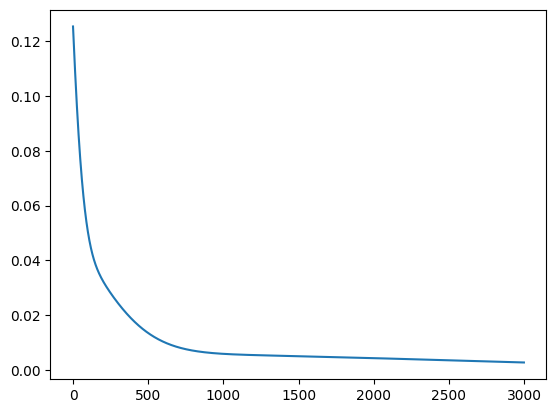

In [29]:
plt.plot(hist)
plt.show()

In [30]:
list(model.parameters())

[Parameter containing:
 tensor([[0.8968, 0.1203]], requires_grad=True),
 Parameter containing:
 tensor([-0.0595], requires_grad=True)]

In [31]:
# Dummy data to draw smooth graph
x_axis = np.linspace(1,50,50) # [ 1 , 2, 3, 4, ...., 50]
x_dummy = [[xval**2, xval] for xval in x_axis]
scaleF = MinMaxScaler()
x_dummyN = scaleF.fit_transform( x_dummy )

predN = model(torch.FloatTensor(x_dummyN)).detach().numpy()
pred = scaleL.inverse_transform(predN)
pred

array([[ -504.34558 ],
       [ -465.8607  ],
       [ -419.55536 ],
       [ -365.4296  ],
       [ -303.48346 ],
       [ -233.71689 ],
       [ -156.12991 ],
       [  -70.72249 ],
       [   22.505325],
       [  123.553566],
       [  232.42224 ],
       [  349.11133 ],
       [  473.62085 ],
       [  605.9508  ],
       [  746.1012  ],
       [  894.0719  ],
       [ 1049.863   ],
       [ 1213.4747  ],
       [ 1384.9066  ],
       [ 1564.159   ],
       [ 1751.2318  ],
       [ 1946.1252  ],
       [ 2148.8389  ],
       [ 2359.3728  ],
       [ 2577.7273  ],
       [ 2803.9026  ],
       [ 3037.8977  ],
       [ 3279.7134  ],
       [ 3529.35    ],
       [ 3786.8064  ],
       [ 4052.0837  ],
       [ 4325.1807  ],
       [ 4606.098   ],
       [ 4894.837   ],
       [ 5191.396   ],
       [ 5495.776   ],
       [ 5807.9746  ],
       [ 6127.995   ],
       [ 6455.835   ],
       [ 6791.4956  ],
       [ 7134.978   ],
       [ 7486.2783  ],
       [ 7845.4014  ],
       [ 82

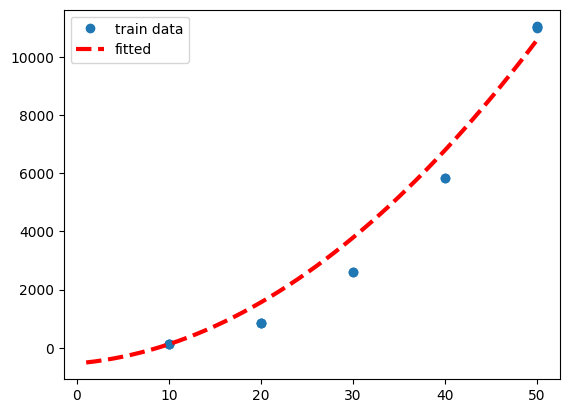

In [32]:
# plt.ylim([0, 25000])
plt.plot(x_data[:,[1]], y_data, 'o', label='train data')
# plt.scatter(x_data, y_data)
# plt.plot(x_data[:,1], np.exp(model(x).data.numpy()), '-r', linewidth=3, label='fitted') # r-- : Red, dashed line

plt.plot(x_axis, pred, 'r--', linewidth=3, label='fitted') # r-- : Red, dashed line
# plt.grid()
plt.legend()
plt.show()